#### **imports**

In [34]:
import pickle
import sys
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid

# Set the random seed
np.random.seed(123)

# Traditional
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

# Tree-Based
from sksurv.ensemble import RandomSurvivalForest

# NN
from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from auton_survival.models.dsm import DeepSurvivalMachines
import torchtuples as tt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lifelines.utils import concordance_index

# Evaluation
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

# Add the outer directory
sys.path.append('../')
from eval_surv_copy import EvalSurv

#### **Load Data**

In [2]:
# Read the pickled DataFrames
with open('data/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('data/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open('data/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)


# Read the pickled DataFrame
with open('data/consolidated_pat_tbl.pickle', 'rb') as file:
    consolidated_pat_tbl = pickle.load(file)

#### **Non-Param**

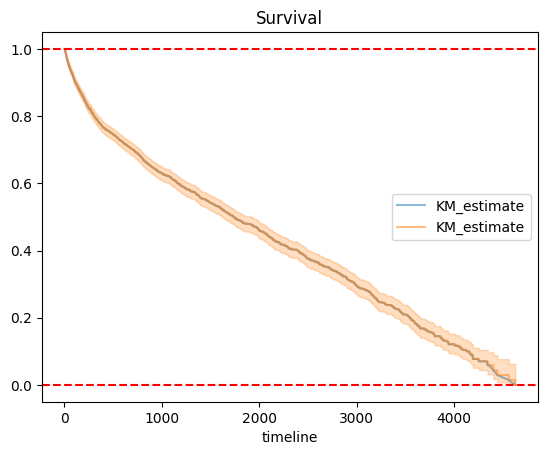

In [3]:
kmf = KaplanMeierFitter()

T = x_train["time_to_event"]
E = x_train["death"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot(alpha = 0.5)

plt.title('Survival');

kmf.plot_survival_function(alpha = 0.5);

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

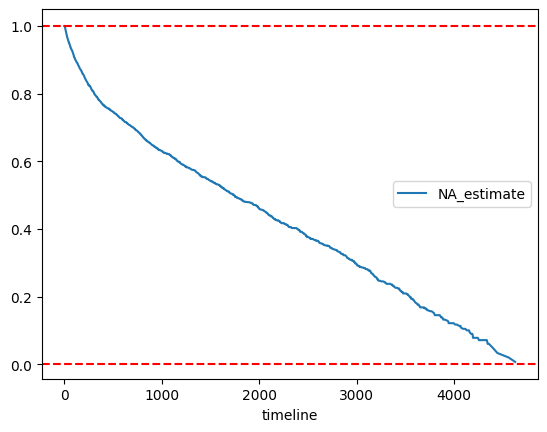

In [4]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
np.exp(-naf.cumulative_hazard_).plot()
# naf.plot_survival_function()

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

#### **Semi-Param**

In [5]:
cph = CoxPHFitter(penalizer = 0.01)
cph.fit(x_train, duration_col='time_to_event', event_col='death', fit_options = {'step_size':0.1})
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4138 total observations, 2738 right-censored observations>
             duration col = 'time_to_event'
                event col = 'death'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4138
number of events observed = 1400
   partial log-likelihood = -9657.23
         time fit was run = 2023-07-19 14:27:14 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
cholesterol   -0.12       0.89       0.03            -0.17            -0.06                 0.84                 0.94
sodium        -0.03       0.97       0.03            -0.09             0.02                 0.91                 1.02
lymphocyte    -0.04       0.96       0.03            -0.10             0.03                 0.91                 1.03
hemoglobin    -0.41       0.66       0.03            -0.48            -0.34                 0.62                 0.71
temperature   -0.02       0.98       0.02            -0.06             0.03                 0.94                 1.03
heartrate      0.08       1.08       0.03             0.02             0.15                 1.02                 1.16
resprate       0.14       1.15       0.03             0.08             0.20                 1.08                 1.22
o2sat         -0.25       0.78       0.06            -0.37            -0.13                 0.69                 0.88
sbp           -0.02       0.98       0.03            -0.09             0.04                 0.92                 1.04
dbp            0.01       1.02       0.06            -0.10             0.13                 0.91                 1.14
acebutolol    -0.25       0.78       0.41            -1.05             0.55                 0.35                 1.73
amlodipine    -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
atenolol       0.02       1.02       0.01             0.01             0.03                 1.01                 1.03
benazepril    -0.12       0.88       0.12            -0.36             0.11                 0.70                 1.12
candesartan    0.03       1.03       0.08            -0.13             0.19                 0.87                 1.21
captopril     -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
diltiazem     -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
felodipine    -0.03       0.97       0.02            -0.08             0.01                 0.93                 1.01
irbesartan    -0.00       1.00       0.03            -0.06             0.05                 0.95                 1.05
lisinopril    -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
moexipril     -0.05       0.95       0.04            -0.13             0.03                 0.87                 1.03
nadolol       -0.01       0.99       0.01            -0.04             0.02                 0.96                 1.02
nebivolol     -0.99       0.37       1.39            -3.71             1.74                 0.02                 5.69
nicardipine   -0.12       0.89       0.17            -0.44             0.21                 0.64                 1.24
nifedipine     0.03       1.03       0.08            -0.12             0.19                 0.89                 1.21
olmesartan     0.09       1.09       0.22            -0.34             0.52                 0.71                 1.68
propranolol   -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
quinapril     -0.03       0.97       0.04            -0.10             0.04                 0.90                 1.04
ramipril       0.00     

<Axes: >

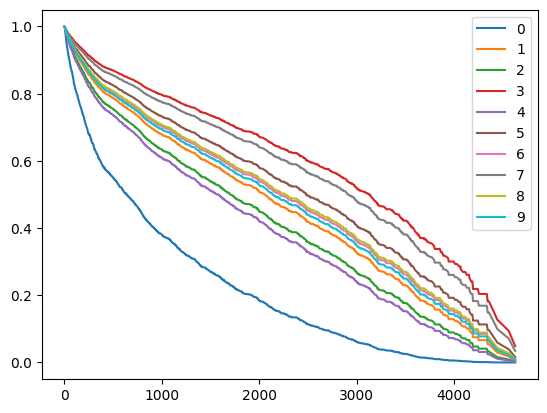

In [6]:
cph.predict_survival_function(x_test.iloc[:10]).plot()

#### **Param**

In [7]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01)
eps = 1e-8
x_train['time_to_event'] = x_train['time_to_event'] + eps
aft.fit(x_train, duration_col='time_to_event', event_col='death')

aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 4138 total observations, 2738 right-censored observations>
             duration col = 'time_to_event'
                event col = 'death'
                penalizer = 0.01
   number of observations = 4138
number of events observed = 1400
           log-likelihood = -11924.424
         time fit was run = 2023-07-19 14:27:17 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                            
lambda_ 0            -0.397      0.673      0.281           -0.948            0.155                0.388                1.167
        1             0.326      1.385      0.233           -0.130            0.782                0.878                2.185
        2             0.329      1.390      0.271           -0.203            0.861                0.817                2.366
        3            -0.404      0.668      0.481           -1.346            0.538                0.260                1.713
        4            -0.243      0.784      0.262           -0.757            0.270                0.469                1.311
        5            -0.188      0.829      0.228           -0.634            0.258                0.530                1.295
        acebutolol    0.273      1.313      0.413           -0.537            1.082                0.585                2.951
        amlodipine    0.007      1.007      0.003            0.001            0.012                1.001                1.012
        atenolol     -0.026      0.974      0.007           -0.040           -0.013                0.961                0.987
        benazepril    0.141      1.151      0.136           -0.125            0.407                0.882                1.503
        candesartan  -0.023      0.977      0.095           -0.210            0.163                0.811                1.177
        captopril     0.002      1.002      0.002           -0.003            0.007                0.997                1.007
        cholesterol   0.127      1.135      0.032            0.065            0.189                1.067                1.208
        dbp          -0.017      0.983      0.068           -0.151            0.116                0.860                1.123
        diltiazem     0.002      1.002      0.002           -0.002            0.005                0.998                1.005
        felodipine    0.038      1.039      0.025           -0.011            0.088                0.989                1.092
        heartrate    -0.086      0.918      0.037           -0.159           -0.012                0.853                0.988
        hemoglobin    0.464      1.591      0.039            0.387            0.541                1.473                1.718
        irbesartan    0.004      1.004      0.030           -0.054            0.063                0.947                1.065
        lisinopril    0.014      1.014      0.003            0.007            0.020                1.007                1.021
        lymphocyte    0.042      1.043      0.036           -0.029            0.114                0.971                1.120
        moexipril     0.064      1.066      0.047           -0.028            0.156                0.972                1.168
        nadolol       0.015      1.015      0.017           -0.018            0.048                0.982                1.049
        nebivolol     1.072      2.921      1.409           -1.689            3.833                0.185               46.180
        nicardipine   0.127      1.136      0.181           -0.229            0.483                0.796                1.621
        nifedipine   -0.027      0.973      0.092           -0.207            0.152                0.813                1.165
        o2sat         0.283      1.327      0.067            0.151            0.415              

<Axes: >

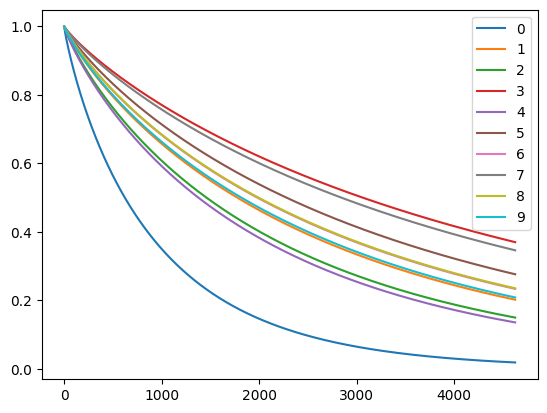

In [8]:
aft.predict_survival_function(x_test.iloc[:10]).plot()

#### **RSF**

In [9]:
# Train - Create a structured array
y_train = np.array([(x, y) for x, y in zip(x_train['death'].astype('bool') , x_train['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])

# Test - Create a structured array
y_test = np.array([(x, y) for x, y in zip(x_test['death'].astype('bool') , x_test['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])

# Val - Create a structured array
y_val = np.array([(x, y) for x, y in zip(x_val['death'].astype('bool') , x_val['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])


In [10]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1234, oob_score = True
)
rsf.fit(x_train.iloc[: , :-2], y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, oob_score=True,
                     random_state=1234)

In [11]:
# Concordance
rsf.score(x_test.iloc[: , :-2], y_test) , rsf.score(x_val.iloc[: , :-2], y_val)

(0.6949833216292135, 0.6772342010330609)

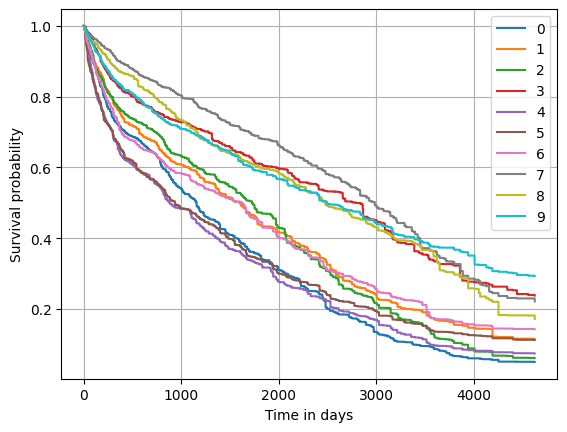

In [12]:
surv_10 = rsf.predict_survival_function(x_test.iloc[: , :-2][:10], return_array=True)

for i, s in enumerate(surv_10):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

shapes : (1035, 1035, 1035, 1035)
td-concordance 0.6859638342696629
integrated brier score 0.19997891902188117


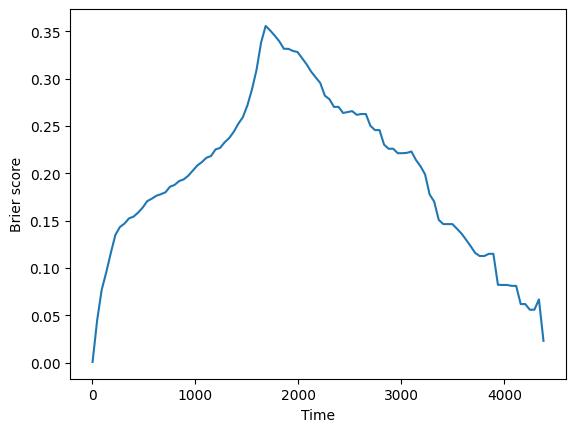

In [13]:
## td-concordance

surv_rsf = rsf.predict_survival_function(x_test.iloc[: , :-2], return_array=True)

from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(surv_rsf.T), x_test['time_to_event'].to_numpy(), x_test['death'].to_numpy(), censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(x_test['time_to_event'].min(), x_test['time_to_event'].max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **PyCox**

0:	[0s / 0s],		train_loss: 1.8385,	val_loss: 1.6736
1:	[0s / 0s],		train_loss: 1.6569,	val_loss: 1.5350
2:	[0s / 0s],		train_loss: 1.5334,	val_loss: 1.4012
3:	[0s / 0s],		train_loss: 1.3962,	val_loss: 1.2579
4:	[0s / 0s],		train_loss: 1.2441,	val_loss: 1.1162
5:	[0s / 0s],		train_loss: 1.0981,	val_loss: 0.9949
6:	[0s / 0s],		train_loss: 0.9894,	val_loss: 0.8984
7:	[0s / 0s],		train_loss: 0.9005,	val_loss: 0.8297
8:	[0s / 0s],		train_loss: 0.8490,	val_loss: 0.7897
9:	[0s / 0s],		train_loss: 0.7931,	val_loss: 0.7625
10:	[0s / 0s],		train_loss: 0.7921,	val_loss: 0.7458
11:	[0s / 0s],		train_loss: 0.7658,	val_loss: 0.7339
12:	[0s / 0s],		train_loss: 0.7550,	val_loss: 0.7272
13:	[0s / 1s],		train_loss: 0.7530,	val_loss: 0.7209
14:	[0s / 1s],		train_loss: 0.7516,	val_loss: 0.7171
15:	[0s / 1s],		train_loss: 0.7463,	val_loss: 0.7135
16:	[0s / 1s],		train_loss: 0.7337,	val_loss: 0.7102
17:	[0s / 1s],		train_loss: 0.7352,	val_loss: 0.7069
18:	[0s / 1s],		train_loss: 0.7243,	val_loss: 0.7075
19:

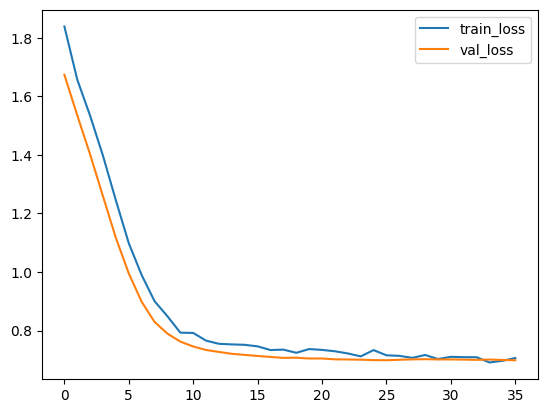

In [14]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

# one liner func
get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_train = labtrans.fit_transform(*get_target(x_train))
y_val = labtrans.transform(*get_target(x_val))

train = (x_train.iloc[: , :-2].to_numpy().astype('float32'), y_train)
val = (x_val.iloc[: , :-2].to_numpy().astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(x_test)

in_features = x_train.iloc[: , :-2].shape[1]
num_nodes = [32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.002), duration_index=labtrans.cuts)

batch_size = 256
epochs = 500
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train.iloc[:,:-2].to_numpy().astype('float32'), y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

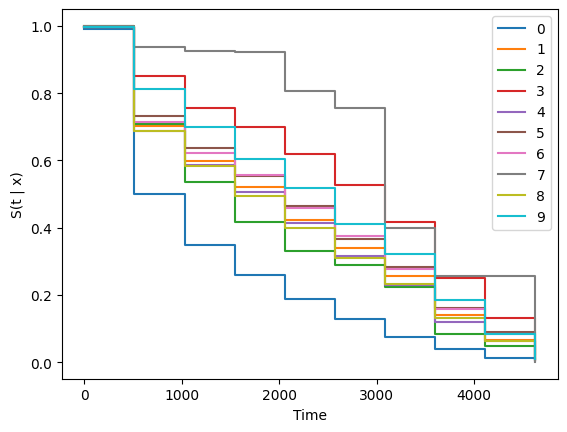

In [15]:
surv = model.predict_surv_df(x_test.iloc[: , :-2].to_numpy().astype('float32'))

surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

shapes : (1035, 1035, 1035, 1035)
td-concordance 0.6049054892322098
integrated brier score 0.18013625723897744


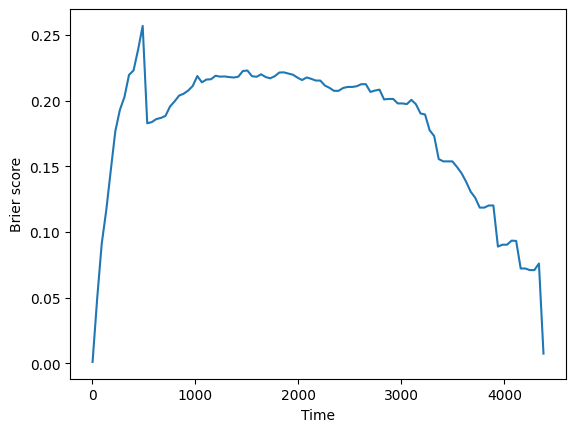

In [16]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **Deep Survival Machines**

In [17]:
import auton_survival
from auton_survival import datasets
from auton_survival.preprocessing import Preprocessor
from auton_survival.models.dsm import DeepSurvivalMachines
import numpy as np

# horizons = [0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.0]
# times = np.quantile(consolidated_pat_tbl['time_to_event'].to_numpy()[consolidated_pat_tbl['death'].to_numpy()==1], horizons).tolist()
times = list(labtrans.cuts[:])
# times

In [18]:
param_grid = {'k' : [6],
              'distribution' : ['LogNormal'],
              'learning_rate' : [1e-4],
              'layers' : [ [], [100], [100, 100] ]
             }

params = ParameterGrid(param_grid)

models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train.iloc[: , :-2].to_numpy(), x_train['time_to_event'].to_numpy(), x_train['death'].to_numpy() ,
              iters = 100 , 
              learning_rate = param['learning_rate']
            )
    models.append([[model.compute_nll(x_val.iloc[: , :-2].to_numpy(), x_val['time_to_event'].to_numpy(), x_val['death'].to_numpy()), 
                    model]])
best_model = min(models)
model = best_model[0][1]

  0%|          | 0/10000 [00:00<?, ?it/s]

 30%|███       | 30/100 [00:11<00:27,  2.58it/s]


In [19]:
# Inference
out_risk = model.predict_risk(x_test.iloc[: , :-2].to_numpy().astype('float64'), times)
out_survival = model.predict_survival(x_test.iloc[: , :-2].to_numpy().astype('float64'), times)

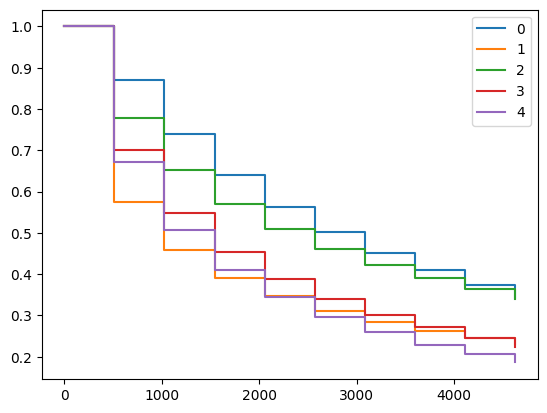

In [20]:
for i , surv in enumerate(out_survival[20:25 , :]):
    plt.step(times , surv , where = 'post' , label = i)
    plt.legend()

shapes : (1035, 1035, 1035, 1035)
td-concordance 0.5788565074906367
integrated brier score 0.27092643803340016


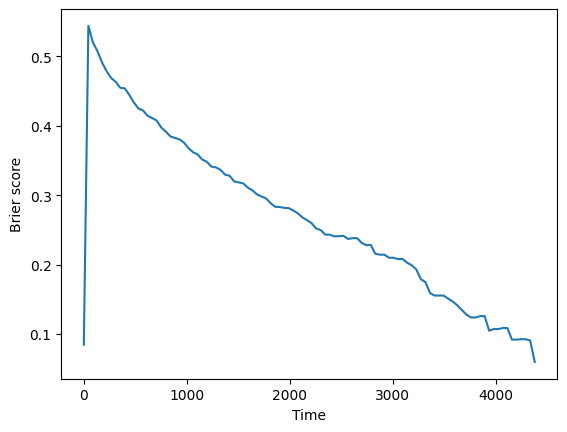

In [21]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(out_survival.T), durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **DeepSurv**

In [22]:
# Simple feedforward NN to implement DeepSurv

class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x))
        return output

In [23]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def PartialLogLikelihood(self , logits, fail_indicator, ties = 'noties'):
        '''
        fail_indicator: 1 if the sample fails, 0 if the sample is censored.
        logits: raw output from model 
        ties: 'noties' or 'efron' or 'breslow'
        reference -> https://github.com/runopti/stg/blob/master/python/stg/losses.py
        '''
        logL = 0
        # pre-calculate cumsum
        # cumsum_y_pred = torch.cumsum(logits, 0)
        hazard_ratio = torch.exp(logits)
        cumsum_hazard_ratio = torch.cumsum(hazard_ratio, 0)
        if ties == 'noties':
            log_risk = torch.log(cumsum_hazard_ratio)
            likelihood = logits - log_risk
            # dimension for E: np.array -> [None, 1]
            uncensored_likelihood = likelihood * fail_indicator
            logL = -torch.sum(uncensored_likelihood)
        else:
            raise NotImplementedError()
        # negative average log-likelihood
        observations = torch.sum(fail_indicator, 0)
        return 1.0*logL / observations

In [24]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, events):
        self.data = features
        self.events = events
        assert self.data.shape[0] == self.events.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        eve = self.events[index] # events
        return cov , eve

In [25]:
input_size = x_train.iloc[: , :-2].shape[1]
hidden_size = 64
output_size = 1 # the output is the hazard

# Create an instance of your custom dataset
dataset = MyDataset(torch.Tensor(x_train.iloc[: , :-2].to_numpy()).to(torch.float32), 
                    torch.Tensor(x_train.iloc[: , -1].to_numpy()).to(torch.float32)
                    )

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 1000
learning_rate = 0.01
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
patience = 50

# build net
# net = MLP(input_size , hidden_size , output_size)
net = MLP(
    input_size =  input_size, 
    hidden_size = 100 , 
    output_size = output_size,
    dropout_rate = 0.1
)

# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

In [26]:
l = generic_Loss()

best_loss = np.Inf

cov_val = torch.Tensor(x_val.iloc[: , :-2].to_numpy()).to(torch.float32)
eve_val = torch.Tensor(x_val.iloc[: , -1].to_numpy()).to(torch.float32)

# Training loop
for epoch in range(num_epochs):
    for batch_id , (cov , eve) in enumerate(dataloader):
        # Prime for training
        net.train()

        # forward pass
        phi_train = net(cov)

        # get loss
        loss = l.PartialLogLikelihood(logits = phi_train , fail_indicator = eve)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        # Prime for evaluation
        net.eval()
        with torch.no_grad():
            phi_val = net(cov_val)
            val_loss = l.PartialLogLikelihood(logits = phi_val , fail_indicator = eve_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break


    if (epoch%50==0): print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 

Epoch 1: Training Loss: 120.6872, Val Loss: 8049.5933
Epoch 51: Training Loss: 1168.9514, Val Loss: 7975.6001
Epoch 101: Training Loss: 1168.8987, Val Loss: 7981.8774
Epoch 151: Training Loss: 1171.9152, Val Loss: 7977.6909
Epoch 201: Training Loss: 1167.2465, Val Loss: 7979.9326
Epoch 251: Training Loss: 1168.5819, Val Loss: 7977.8477
Epoch 301: Training Loss: 1170.0095, Val Loss: 7988.3062
Epoch 351: Training Loss: 1167.7970, Val Loss: 7976.9609
Epoch 401: Training Loss: 1167.0167, Val Loss: 7974.0010
Epoch 451: Training Loss: 1168.7764, Val Loss: 7979.6108
Epoch 501: Training Loss: 1168.5256, Val Loss: 7977.2935
Epoch 551: Training Loss: 1168.7471, Val Loss: 7973.5332
Epoch 601: Training Loss: 1168.7760, Val Loss: 7982.4048
Epoch 651: Training Loss: 1168.9419, Val Loss: 7976.1802
Epoch 701: Training Loss: 1169.5317, Val Loss: 7973.9424
Epoch 751: Training Loss: 1167.9133, Val Loss: 7981.9248
Epoch 801: Training Loss: 1170.6646, Val Loss: 7982.4761
Epoch 851: Training Loss: 1168.9513

In [27]:
cov_test = torch.Tensor(x_test.iloc[: , :-2].to_numpy()).to(torch.float32)
dur_test = torch.Tensor(x_test.iloc[: , -2].to_numpy()).to(torch.float32)
eve_test = torch.Tensor(x_test.iloc[: , -1].to_numpy()).to(torch.float32)
print(f'test shape: {cov_test.shape}')

with torch.no_grad():
    risk_test = torch.exp(net(cov_test))

concordance_index(dur_test, risk_test, eve_test) 

test shape: torch.Size([1035, 38])


0.553411019428839

#### **My Model**

#### **Time Independent**

Flow
_____
1. measure similarity
2. cluster
3. build cluster-wise nn
4. predict

In [33]:
# Clustering
from sklearn.cluster import KMeans

# Specify the number of clusters (K)
_clusters = 3

# Create a KMeans instance and fit the data
kmeans = KMeans(n_clusters=_clusters , n_init = 'auto')
kmeans.fit(x_train.iloc[: , :-2])

# Add cluster
x_train['cluster'] = kmeans.labels_

x_train = x_train[
    [
        'cholesterol', 'sodium', 'lymphocyte', 'hemoglobin', 'temperature',
        'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acebutolol',
        'amlodipine', 'atenolol', 'benazepril', 'candesartan', 'captopril',
        'diltiazem', 'felodipine', 'irbesartan', 'lisinopril', 'moexipril',
        'nadolol', 'nebivolol', 'nicardipine', 'nifedipine', 'olmesartan',
        'propranolol', 'quinapril', 'ramipril', 'trandolapril', 'valsartan',
        'verapamil', 'cluster', '0', '1', '2', '3', '4', '5', 'time_to_event', 
        'death'
    ]
]

x_train_grouped = 

,cholesterol,sodium,lymphocyte,hemoglobin,temperature,heartrate,resprate,o2sat,sbp,dbp,...,verapamil,cluster,0,1,2,3,4,5,time_to_event,death
0,1.523181,0.740209,0.215037,1.923905,0.020020,-0.543741,0.207249,-0.529631,1.466132,0.493006,...,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,244.0,1.0
1,0.839491,-2.074671,1.681019,-1.028484,0.113769,-0.724447,-0.877901,0.366538,-0.041841,-0.197310,...,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,883.0,0.0
2,2.179524,0.373157,0.330571,0.341616,0.054625,1.121944,-0.438766,0.148264,0.061779,-0.128966,...,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,411.0,0.0
3,-0.555237,-2.215273,-0.183546,-0.883303,0.114608,1.566067,1.500452,0.247283,-0.560418,0.207008,...,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,135.0,1.0
4,-0.555237,-0.473185,-0.039784,-0.508311,-0.118401,-0.874312,-0.286072,0.321546,0.689435,-0.139085,...,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4133,-0.473194,0.037575,-0.156398,-1.438485,0.133525,-1.044648,-0.813863,0.066466,-0.090435,-0.060377,...,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,216.0,0.0
4134,3.820380,1.351019,0.072510,0.470803,-0.040885,0.378892,-0.818039,0.343107,0.295059,0.036540,...,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1490.0,1.0
4135,0.962555,-0.669873,0.379160,-0.633131,-0.007035,-1.107304,-0.858675,-0.179734,-0.337328,-0.102401,...,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,772.0,0.0
4136,3.265224,1.638587,0.125634,0.463817,0.204120,-0.807743,-1.202238,0.247283,0.701563,-0.161574,...,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
